In [1]:
import os
import sys
import humanfriendly
import pandas as pd
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import folium
import numpy as np
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer

# Files

In [3]:
for (root,dirs,files) in os.walk('../Data/Metagenomics/', topdown=True): 
        print ('Root-> ',root) 
        print ('Directories-> ',dirs) 
        [print(i,' ',humanfriendly.format_size(os.stat(root+'/'+i).st_size)) for i in files] 
        print ('--------------------------------') 

Root->  ../Data/Metagenomics/
Directories->  []
abundance.txt   31.95 MB
abundance_stoolsubset.txt   13.43 MB
archive.zip   83.46 MB
Features.csv   15.18 MB
markers2clades_DB.txt   176.8 MB
marker_presence.txt   2.1 GB
Targets.csv   14.56 KB
--------------------------------


Let us look at only abundance_stoolsubset.txt for now as this is small.

## Data Cleaning

In [4]:
a_stool=pd.read_csv('../Data/Metagenomics/abundance_stoolsubset.txt',sep="\t",index_col="dataset_name",dtype=str).T
a_stool=a_stool.reset_index().rename(columns={'index':'dataset'})

The following 211 attributes are meta data about the subject.

In [5]:
metadata=a_stool.columns[:211]
metadata

Index(['dataset', 'sampleID', 'subjectID', 'bodysite', 'disease', 'age',
       'gender', 'country', 'sequencing_technology', 'pubmedid',
       ...
       'statins', 'insulin', 'oral_anti-diabetic_medication',
       'years_in_sweden', 'tnm_stage', 'ajcc_stage', 'localization', 'fobt',
       'wif-1_gene_methylation_test', 'group'],
      dtype='object', name='dataset_name', length=211)

In [6]:
missing_values=pd.Series(*list(map(
        list,zip(
            *[       [round(100*a_stool[a_stool[i].isin(['nd','na','-',' -','- '])].shape[0]/a_stool.shape[0],2),  i]\
          for i in a_stool.columns]
        )
)))
missing_values[missing_values>30]

camp                                           98.09
paired_end_insert_size                         86.02
read_length                                    86.02
total_reads                                    86.02
matched_reads                                  86.02
uniquely_matching_reads                        86.02
uniquely_matched_reads                         86.02
gene_number                                    86.02
gene_number_for_11m_uniquely_matched_reads     86.02
hitchip_probe_number                           86.02
gene_count_class                               86.02
hitchip_probe_class                            86.02
rna_sampleid                                  100.00
infant_gender                                 100.00
infant_gestation_weeks                        100.00
cohort                                        100.00
less_than_29weeks                             100.00
sample_collection_days                        100.00
collectionweek                                

In [7]:
#The following metadata columns are going to be consideredas all other attributes are missing in most of the cases.
cols=[print(i) or i for i in missing_values[missing_values<30].index if not i.startswith('k__')]
len(cols)

dataset
sampleID
subjectID
bodysite
disease
age
gender
country
sequencing_technology
pubmedid
bmi
#SampleID


12

Dropping columns with more than 30% missing data.<br>
<span style="color:blue">To Do:</span><br>
Analyze these metadata columns and include them in modelling

In [8]:
rem_cols=metadata.difference(cols)
print('Dropping {} attributes '.format(len(rem_cols)))
try:
    a_stool.drop(columns=rem_cols,inplace=True)
except KeyError as e:
    print('Ignoring as these Attributes are dropped already.')
    pass

Dropping 199 attributes 


# subjectID
There are some repeating subjectIDs and it is not clear why some subjects are sampled multiple times<br>
Removing duplicates belonging to these subjects for now.

In [9]:
print('There are {} subjects'.format(a_stool['subjectID'].nunique()))
subject_counts=a_stool['subjectID'].value_counts().reset_index()
repeating_subjects=subject_counts[subject_counts['subjectID']>1]['index'].values
print('There are {}  subjects with  multiple samples'.format(len(repeating_subjects)))
a_stool.sort_values(['subjectID','sampleID'],inplace=True)
a_stool.drop_duplicates(['subjectID'],inplace=True)

There are 1562 subjects
There are 314  subjects with  multiple samples


## Source

Data is sourced from 13 different public datasets.
The following pie chart describes percentage contributions


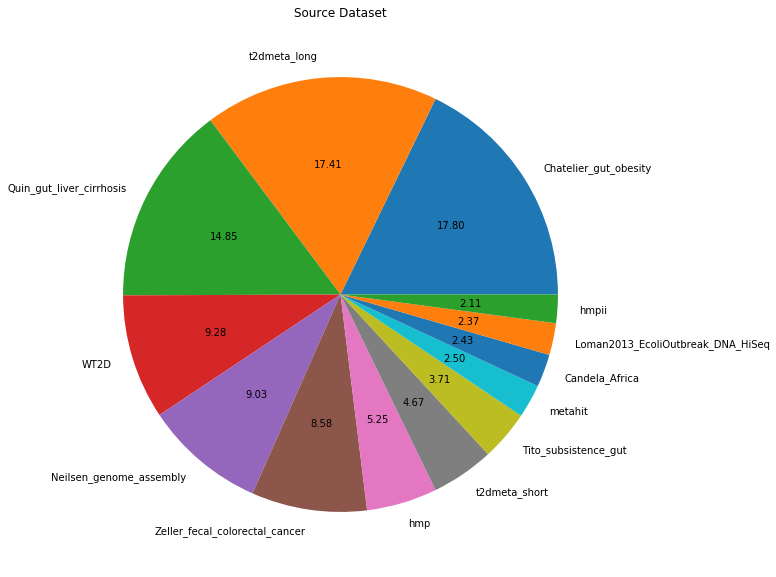

In [10]:
a_stool['dataset']=a_stool['dataset'].map(lambda x:x.split('.')[0])
dataset_pivot=a_stool['dataset'].value_counts()#.reset_index().rename(columns={'index':'dataset','dataset':'Counts'})
print('Data is sourced from {} different public datasets.\nThe following pie chart describes percentage contributions'.format(dataset_pivot.shape[0]))
ax=dataset_pivot.plot(kind='pie',figsize=(10, 10),title='Source Dataset',autopct='%.2f',label='')
plt.show()

There are 17 unique diseases in the data.
Following is the frequency plot


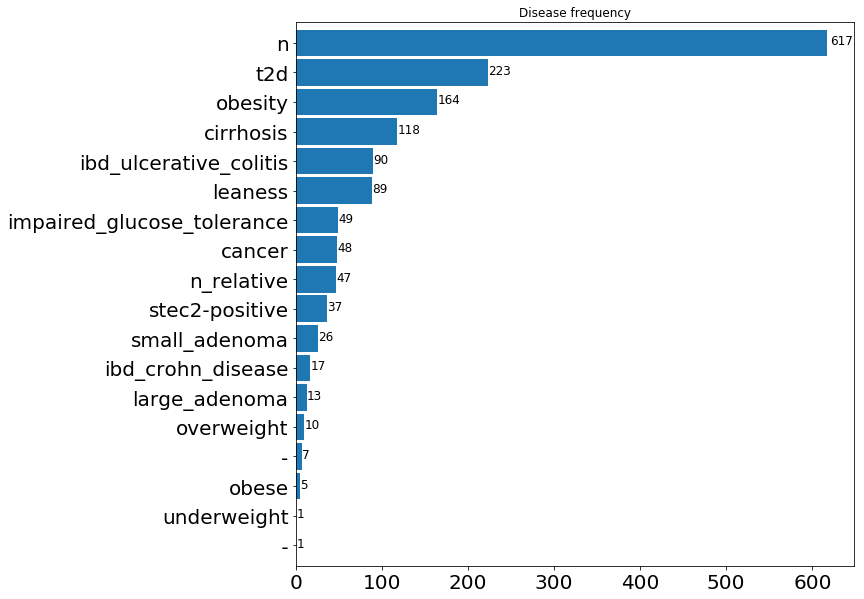

In [11]:
print('There are {} unique diseases in the data.\nFollowing is the frequency plot'.format(a_stool['disease'].nunique()-1))
ax=a_stool['disease'].value_counts().plot(kind='barh',width=0.9,figsize=(10, 10),title='Disease frequency',label='',fontsize=20)
plt.gca().invert_yaxis()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() * 1.005, p.get_y()+0.5 ),fontsize=12)
plt.show()

<b><font size="5">n</font></b>&nbsp;&nbsp;&nbsp;&#8594;&nbsp;&nbsp;&nbsp;
 No Disease (Healthy Subject)<br>
<b><font size="5">td2</font></b>&nbsp;&nbsp;&nbsp;&#8594;&nbsp;&nbsp;&nbsp;
 Type 2 Diabetes<br>

## Country

In [12]:
mapping_dict={
             'Usa':'United States of America',
             'Tanzania':'United Republic of Tanzania',
             'Yugoslavia':'Serbia'}
a_stool['country']=a_stool['country'].map(lambda x:x[0].upper()+x[1:])
a_stool['country']=a_stool['country'].map(lambda x:mapping_dict.get(x,x))
country_data=a_stool['country'].value_counts().reset_index().rename(columns={'index':'Country','country':'subjectCount'})
country_data

,Country,subjectCount
0,China,576
1,Denmark,280
2,Spain,180
3,France,135
4,Sweden,130
5,United States of America,104
6,Germany,41
7,Peru,36
8,Nd,33
9,United Republic of Tanzania,27


In [13]:
m=folium.Map()
#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data=country_shapes,
    name='Subjects DIstribution',
    data=country_data,
    #The column aceppting list with 2 value; The country name and  the numerical value
    columns=['Country', 'subjectCount'],
    key_on='feature.properties.name',
    fill_color='PuRd',
    nan_fill_color='white'
).add_to(m)
m

In [14]:
grp=a_stool.groupby(['country'])['disease']
country_data=[]
for i in grp:
    l=i[1].value_counts().reset_index()
    try:
        country_data.append([i[0],l[l['index']=='t2d']['disease'].values[0]])
    except IndexError as i:
        pass
country_data=pd.DataFrame(country_data,columns=['Country','t2dcount'])
m=folium.Map()
#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data=country_shapes,
    name='Subjects DIstribution',
    data=country_data,
    #The column aceppting list with 2 value; The country name and  the numerical value
    columns=['Country', 't2dcount'],
    key_on='feature.properties.name',
    fill_color='PuRd',
    nan_fill_color='white'
).add_to(m)
m

Countries like USA donot have t2d cases at all which is counter intuitive.<br>
Let us drop country column from input features to the model as this may add sampling bias.

## Disease Category
For this study we group all diseases except t2d into Others actegory

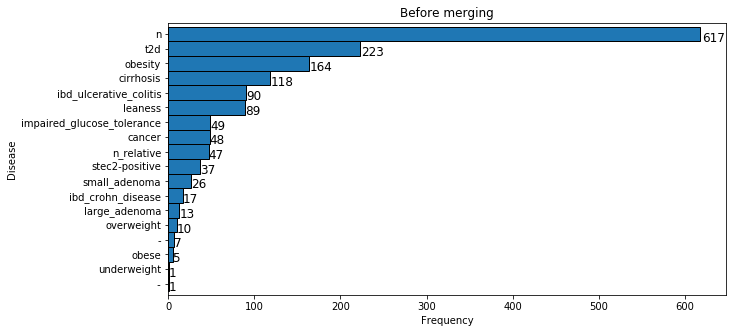

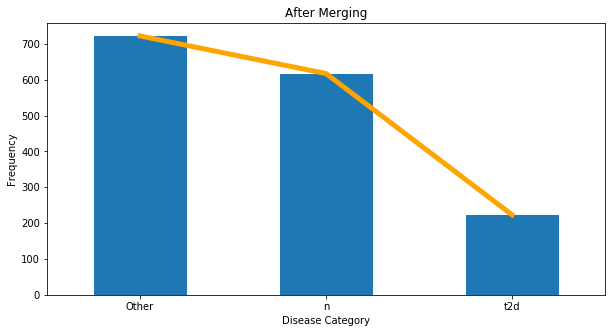

In [15]:
ax=a_stool['disease'].value_counts()[:30].plot(kind='barh',figsize=(10,5),width=1,edgecolor='black')
ax.invert_yaxis()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() * 1.005, p.get_y()+1 ),fontsize=12)
plt.xlabel('Frequency')
plt.ylabel('Disease')
plt.title('Before merging')
plt.show()
a_stool['disease_category']=a_stool['disease'].map(lambda x:'Other' if x not in ['n','t2d'] else x)
a_stool['disease_category'].value_counts().sort_index().plot(color='orange',linewidth=5,figsize=(10,5))
a_stool['disease_category'].value_counts().sort_index().plot(kind='bar',rot=0)
plt.xlabel('Disease Category')
plt.ylabel('Frequency')
plt.title('After Merging')
plt.show()

<font size="5">We will take disease_category as Target Variable</font>

## Gender

In [16]:
a_stool['gender'].value_counts()

male      603
female    497
-         278
nd        182
na          1
 -          1
Name: gender, dtype: int64

Since nd,na,- all corresponding to missing data let us combine them.
<br>Let us see if there is a relation between gender and disease

In [17]:
a_stool['gender']=a_stool['gender'].map(lambda x: 'nd' if x not in ('male','female') else x)
contingency_table=pd.crosstab(a_stool['gender'],a_stool['disease_category'])

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px'),('width','150px'),('height','75px'),
                   ("line-height", "9"),("text-align", "center"),('border','2px solid black')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

contingency_table.style.set_table_styles(dfstyle).background_gradient(cmap='viridis')

disease_category,Other,n,t2d
gender,,,
female,180,253,64
male,202,295,106
nd,340,69,53


We c annot draw much inference from this.Lets do a chi square test and see

In [18]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
stat,p_value,deg_of_freedom,expected_values=chi2_contingency(contingency_table)
critical_value=chi2.ppf(0.999,deg_of_freedom)
for i in [stat,p_value,deg_of_freedom,expected_values,critical_value]:
    print(namestr(i,globals())[0],' = ',i) 
    print('\n')

stat  =  215.09008795905282


p_value  =  2.1349654073852994e-45


deg_of_freedom  =  4


expected_values  =  [[229.72727273 196.31818182  70.95454545]
 [278.7234315  238.18886044  86.08770807]
 [213.54929577 182.49295775  65.95774648]]


critical_value  =  18.46682695290317




We can see from the results of chi2 test on contingency table that chi2 value is greater than critical value of chi2 distribution for 99.9% confidence and 4 degrees of freedom.
Hence we can reject null hypotheses(gender and disease are independent) and say Gender and disease are dependent.<br>
<font size="5">We will retain gender as an input variable.</font>

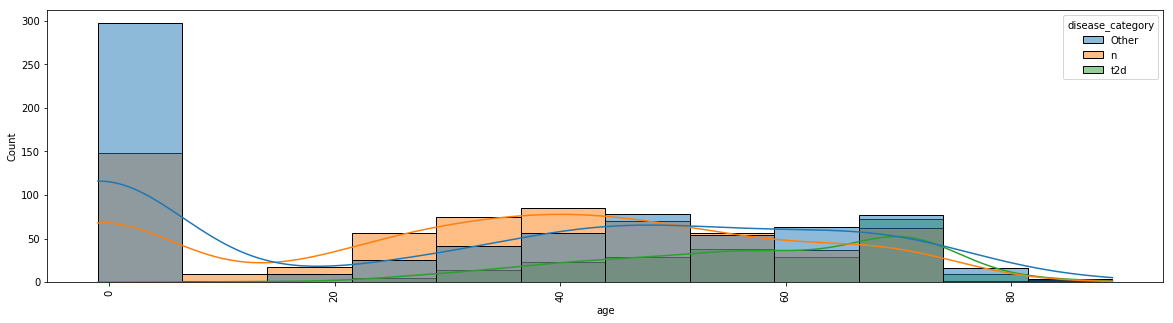

In [19]:
a_stool['age'].replace('nd',-1,inplace=True)
a_stool['age'].replace(' -',-1,inplace=True)
a_stool['age'].replace('na',-1,inplace=True)
a_stool['age']=a_stool['age'].astype(np.float64)
plt.figure(figsize=(20,5))
sns.histplot(data=a_stool,x='age',kde=True,hue='disease_category')
plt.xticks(rotation=90)
plt.show()

In [20]:
print(a_stool[a_stool['age']<10]['disease_category'].value_counts())
a_stool=a_stool[(a_stool['age']<0) | (a_stool['age']>=10)]

Other    297
n        152
Name: disease_category, dtype: int64


Intuiively we know it is extremely rare for kids to have diabetes.Data also supports this as there are no t2d subjects under 10 years.<br>
<font size="5">We will delete data points with age less than 10.</font>

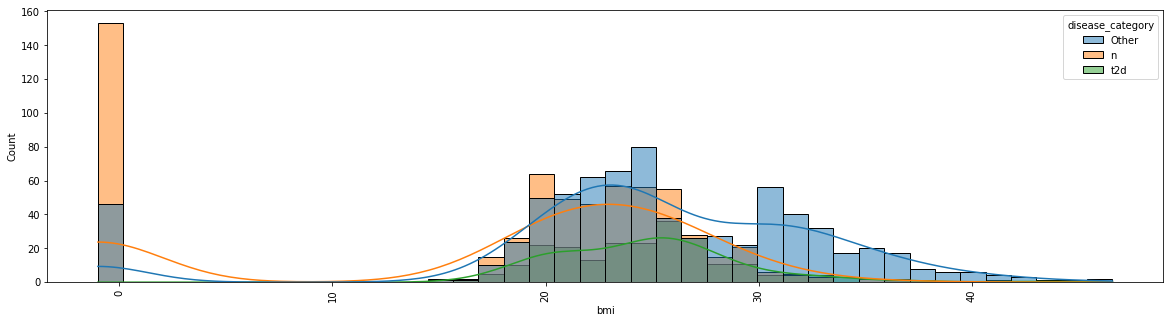

In [21]:
a_stool['bmi'].replace('nd',-1,inplace=True)
a_stool['bmi'].replace(' -',-1,inplace=True)
a_stool['bmi'].replace('na',-1,inplace=True)
a_stool['bmi']=a_stool['bmi'].astype(np.float64)
plt.figure(figsize=(20,5))
sns.histplot(data=a_stool,x='bmi',kde=True,hue='disease_category')
plt.xticks(rotation=90)
plt.show()

Subjects with moderate BMI are also susceptible to t2d.This proves that BMI is not an empirical measure of a subject's health.

In [22]:
#Bodysite and 'Sequencing technology' contains only one value in all data points so these don't add any value to inference.
a_stool['bodysite'].nunique(),a_stool['sequencing_technology'].nunique()

(1, 1)

In [23]:
identifying_attributes=['dataset','sampleID','subjectID','pubmedid','#SampleID']
modelling_attributes=['age','gender','bmi']
microbials=list(filter(lambda x:True if x.startswith('k__') else False,a_stool.columns.values))

Since Age and BMI has a lot of missing values we need to do Imputation.<br>
Let us try using Knn imputer as there aren't many data points.

In [24]:
inputs=modelling_attributes+microbials
output='disease_category'

In [25]:
X=a_stool[inputs]
y=a_stool[output]

In [26]:
#Checking if any of the microbial columns contain -1(missing value)
any(np.sum(X==-1,axis=0)[3:]!=0)

False

In [27]:
X['gender'].unique()

array(['nd', 'female', 'male'], dtype=object)

In [28]:
dummy_encoding={'male':-50,
               'female':50,
               'nd':0}
X_dummy=X.copy()
X_dummy['gender']=X['gender'].map(dummy_encoding)
imputer=KNNImputer(-1,5)
X_imputed=imputer.fit_transform(X_dummy)

In [29]:
X_imputed=pd.DataFrame(X_imputed,columns=X_dummy.columns.values)
X_imputed

,age,gender,bmi,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
0,46.6,0.0,31.860,0.15340,0.15340,0.15340,0.15340,0.15340,0.15114,0.15114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38.0,50.0,22.838,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,48.2,50.0,22.390,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,56.4,-50.0,23.210,0.03348,0.03348,0.03348,0.03348,0.03348,0.03348,0.01624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,37.8,50.0,23.000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,57.4,-50.0,24.462,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,49.8,-50.0,24.054,0.10135,0.10135,0.10135,0.10135,0.10135,0.10135,0.10135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,34.8,50.0,23.818,0.07434,0.07434,0.07434,0.07434,0.07434,0.07434,0.05455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,45.0,-50.0,25.606,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,38.4,-50.0,23.416,0.01801,0.01801,0.01801,0.01801,0.01801,0.01801,0.01224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let us look at the covariance of the attributes.

In [30]:
covariances=X_imputed.cov()
covariances

,age,gender,bmi,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
age,240.560144,23.308242,26.753500,1.358994,1.358994,1.357042,1.357042,1.357042,1.329444,1.219697,...,-1.348397e-04,2.195322e-05,2.195322e-05,8.643421e-04,8.643421e-04,8.643421e-04,8.643421e-04,1.007266e-02,-3.798815e-03,-3.798815e-03
gender,23.308242,1742.007898,-5.053366,1.926709,1.926709,1.927884,1.927884,1.927884,1.696103,1.911991,...,-2.713718e-03,-1.562553e-03,-1.562553e-03,2.771235e-03,2.771235e-03,2.771235e-03,2.771235e-03,3.229476e-02,3.196863e-02,3.196863e-02
bmi,26.753500,-5.053366,23.256587,-0.374294,-0.374294,-0.374691,-0.374691,-0.374691,-0.359214,-0.372589,...,6.603088e-06,1.662375e-04,1.662375e-04,-5.408234e-05,-5.408234e-05,-5.408234e-05,-5.408234e-05,2.998505e-03,2.369539e-03,2.369539e-03
k__Archaea,1.358994,1.926709,-0.374294,9.766512,9.766512,9.764986,9.764986,9.764986,9.637471,9.552546,...,1.248497e-04,1.161534e-04,1.161534e-04,-3.909165e-05,-3.909165e-05,-3.909165e-05,-3.909165e-05,1.838549e-03,-4.515852e-04,-4.515852e-04
k__Archaea|p__Euryarchaeota,1.358994,1.926709,-0.374294,9.766512,9.766512,9.764986,9.764986,9.764986,9.637471,9.552546,...,1.248497e-04,1.161534e-04,1.161534e-04,-3.909165e-05,-3.909165e-05,-3.909165e-05,-3.909165e-05,1.838549e-03,-4.515852e-04,-4.515852e-04
k__Archaea|p__Euryarchaeota|c__Methanobacteria,1.357042,1.927884,-0.374691,9.764986,9.764986,9.763467,9.763467,9.763467,9.635975,9.551227,...,1.248704e-04,1.161654e-04,1.161654e-04,-3.907315e-05,-3.907315e-05,-3.907315e-05,-3.907315e-05,1.838765e-03,-4.513717e-04,-4.513717e-04
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,1.357042,1.927884,-0.374691,9.764986,9.764986,9.763467,9.763467,9.763467,9.635975,9.551227,...,1.248704e-04,1.161654e-04,1.161654e-04,-3.907315e-05,-3.907315e-05,-3.907315e-05,-3.907315e-05,1.838765e-03,-4.513717e-04,-4.513717e-04
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,1.357042,1.927884,-0.374691,9.764986,9.764986,9.763467,9.763467,9.763467,9.635975,9.551227,...,1.248704e-04,1.161654e-04,1.161654e-04,-3.907315e-05,-3.907315e-05,-3.907315e-05,-3.907315e-05,1.838765e-03,-4.513717e-04,-4.513717e-04
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevi

Let us try correlation coefficient as the scales of attributes are diffferent

In [31]:
X_imputed.corr()

,age,gender,bmi,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
age,1.000000,0.036006,0.357681,0.028037,0.028037,0.028001,0.028001,0.028001,0.027766,0.025668,...,-0.007123,0.001075,0.001075,0.027337,0.027337,0.027337,0.027337,0.027337,-0.010415,-0.010415
gender,0.036006,1.000000,-0.025106,0.014771,0.014771,0.014783,0.014783,0.014783,0.013164,0.014952,...,-0.053272,-0.028425,-0.028425,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570,0.032570
bmi,0.357681,-0.025106,1.000000,-0.024835,-0.024835,-0.024866,-0.024866,-0.024866,-0.024129,-0.025218,...,0.001122,0.026172,0.026172,-0.005501,-0.005501,-0.005501,-0.005501,0.026172,0.020893,0.020893
k__Archaea,0.028037,0.014771,-0.024835,1.000000,1.000000,1.000000,1.000000,1.000000,0.998961,0.997693,...,0.032732,0.028219,0.028219,-0.006136,-0.006136,-0.006136,-0.006136,0.024764,-0.006145,-0.006145
k__Archaea|p__Euryarchaeota,0.028037,0.014771,-0.024835,1.000000,1.000000,1.000000,1.000000,1.000000,0.998961,0.997693,...,0.032732,0.028219,0.028219,-0.006136,-0.006136,-0.006136,-0.006136,0.024764,-0.006145,-0.006145
k__Archaea|p__Euryarchaeota|c__Methanobacteria,0.028001,0.014783,-0.024866,1.000000,1.000000,1.000000,1.000000,1.000000,0.998962,0.997711,...,0.032743,0.028227,0.028227,-0.006134,-0.006134,-0.006134,-0.006134,0.024770,-0.006143,-0.006143
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,0.028001,0.014783,-0.024866,1.000000,1.000000,1.000000,1.000000,1.000000,0.998962,0.997711,...,0.032743,0.028227,0.028227,-0.006134,-0.006134,-0.006134,-0.006134,0.024770,-0.006143,-0.006143
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,0.028001,0.014783,-0.024866,1.000000,1.000000,1.000000,1.000000,1.000000,0.998962,0.997711,...,0.032743,0.028227,0.028227,-0.006134,-0.006134,-0.006134,-0.006134,0.024770,-0.006143,-0.006143
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,0.027766,0.013164,-0.024129,0.998961,0.998961,0.998962,0.998962,0.998962,1.000000,0.998949,...,0.033149,0.025737,0.025737,-0.006062,-0.006062,-0.006062,-0.006062,0.025218,-0.006071,-0.006071
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibac

Lots of high correlation is present among microbial abundance attributes.This is expected as relative abundance of individual species dictates abundance of strain. We need to perform feature selection as using features with multicollinearity will impact models performance and explainability. 

## Saving Files

In [32]:
X_imputed.to_csv('../Data/Metagenomics/Features.csv')
y.reset_index(drop=True,inplace=True)
y.to_csv('../Data/Metagenomics/Targets.csv')